# Toxic Comment Classification using Deep Learning and NLP

## Introduction

This notebook implements toxic comment classification using deep learning and NLP techniques.

## Dataset

We use the Kaggle Toxic Comment Classification Challenge dataset, which contains labeled comments from Wikipedia - [Dataset Link](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)

# Unzip our Dataset - They are stored as Zip Files 

In [2]:
import zipfile
import os

dir = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'

for file in os.listdir(dir):
    # Specify the path to the zip file you want to unzip
    zip_file_path = os.path.join(dir, file)

    # Specify the directory where you want to extract the contents
    extracted_dir_path = os.path.join('/kaggle/working/', file[:-4])

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extracted_dir_path)

    # The contents of the zip file are now extracted to the 'extracted_dir_path'


# Import Basic Libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Opening the Train Dataset and Data Exploration

In [4]:
# Open the CSV File
train_data = pd.read_csv('/kaggle/working/train.csv/train.csv')

# View the top 5 rows from the file
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Check the columns in the dataset
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
# Check for NULL Values, if any
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
# Check the dataset description
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Check the shape of the dataset
train_data.shape

(159571, 8)

# Data Preprocessing

In [9]:
from tensorflow.keras.layers import TextVectorization

In [10]:
# Split the data into X and y
X = train_data['comment_text']                 # X - The comments from the train_data (Technically, input)
y = train_data[train_data.columns[2:]].values  # y - The labels for each comment (Technically, predictions)

In [11]:
MAX_WORDS = 100000 # Maximum number of words in the vocabulary
MAX_SEQ_LEN = 1500 # Maximum number of 1800 words per sentence

# Initialize Text Vectorizer
vectorizer = TextVectorization(max_tokens = MAX_WORDS,
                              output_sequence_length = MAX_SEQ_LEN,
                              output_mode = 'int')

In [12]:
# Teach our vectorizer about our data
vectorizer.adapt(X.values)

In [13]:
# Checking how the vectorizer is providing output for a sample sentence
vectorizer('Hello World!')

<tf.Tensor: shape=(1500,), dtype=int64, numpy=array([288, 263,   0, ...,   0,   0,   0])>

In [14]:
# Vectorize all the values from X
vectorized_text = vectorizer(X.values)

In [15]:
print(vectorized_text) # Check how our vectorized texts look like
print(f"\n\nLength of X: {len(X)}") # Verify the lengths are same

tf.Tensor(
[[  645    76     2 ...     0     0     0]
 [    1    54  2489 ...     0     0     0]
 [  425   441    70 ...     0     0     0]
 ...
 [32445  7392   383 ...     0     0     0]
 [    5    12   534 ...     0     0     0]
 [    5     8   130 ...     0     0     0]], shape=(159571, 1500), dtype=int64)


Length of X: 159571


In [16]:
# Create a TensorFlow Data Pipeline - usually a good practice

ds = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
ds = ds.cache()
ds = ds.shuffle(120000)    		# Choose Shuffle Buffer Size
ds = ds.batch(16)
ds = ds.prefetch(8)		# Reduces the possibility of Bottlenecking

In [17]:
# Get a sample batch
ds.as_numpy_iterator().__next__()

(array([[   40,    88,     7, ...,     0,     0,     0],
        [    2,  3544,     4, ...,     0,     0,     0],
        [  425, 19123,     2, ...,     0,     0,     0],
        ...,
        [ 4377,    33,   151, ...,     0,     0,     0],
        [   23,  1663,  8219, ...,     0,     0,     0],
        [  451,     1,  9312, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [18]:
# Split the data into train, test and validation splits

train = ds.take(int(len(ds)*.7))                     # Take 70% of the data for training split
val = ds.skip(int(len(ds)*.7)).take(int(len(ds)*.2))  # Take 20% of the data for validation split
test = ds.skip(int(len(ds)*.9)).take(int(len(ds)*.1)) # Take 10% of the data for test split

# Create the Deep Learning Model

In [19]:
# Necessary imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [27]:
# Instantiate Sequential Model
model = Sequential()

# Add embedding layer
model.add(Embedding(MAX_WORDS, 32))

# Add Bidirectional layer for LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Add Fully Connected layers
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))

# Add Final Output Layer
'''
  Here we use activation "sigmoid" instead of "softmax" as we are trying to, in a way, rate the
  toxicity level of the comment under each category, rather than place it in one particular 
  category (classify as belonging to the best class amongst all available classes) 
  
  You can think of it as, this is a Dense(1, activation='sigmoid') layer acting on 6 different columns
  
  Hence this sigmoid will give a value between 0 and 1 for each category, thus rating the comment's
  toxicity under each category.
'''
model.add(Dense(6, activation="sigmoid")) 

In [28]:
model.compile(loss='binary_crossentropy', # Note that it is BinaryCrossEntropy and not Categorical 
             optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          3200000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                      

In [30]:
TCC_history = model.fit(train, 
                        epochs=5,
                        steps_per_epoch=len(train),
                        validation_data=val,
                        validation_steps=int(0.15*len(val)))

Epoch 1/5
6981/6981 [==============================] - 631s 89ms/step - loss: 0.0646 - val_loss: 0.0453
Epoch 2/5
5329/6981 [=====================>........] - ETA: 1:51 - loss: 0.0513

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6981/6981 [==============================] - 464s 66ms/step - loss: 0.0502 - val_loss: 0.0456
Epoch 4/5
6981/6981 [==============================] - 460s 66ms/step - loss: 0.0493 - val_loss: 0.0489
Epoch 5/5
6981/6981 [==============================] - 470s 67ms/step - loss: 0.0493 - val_loss: 0.0477


In [32]:
# Predict on entire validation data
model.predict(val)

1994/1994 [==============================] - 61s 30ms/step


array([[2.41122454e-01, 3.65516491e-04, 3.88157032e-02, 6.60807034e-03,
        4.10477705e-02, 9.91213974e-03],
       [6.50762558e-01, 9.04551335e-03, 2.06543118e-01, 1.84679516e-02,
        2.32216105e-01, 4.66948487e-02],
       [1.10549876e-03, 1.23667565e-08, 1.03940009e-04, 2.38808425e-04,
        8.21305075e-05, 6.22616863e-05],
       ...,
       [4.84177331e-03, 1.82775494e-07, 4.94367327e-04, 5.70029602e-04,
        4.21862758e-04, 2.35151747e-04],
       [1.81274931e-03, 3.04417931e-08, 1.75118621e-04, 3.19477578e-04,
        1.41978686e-04, 9.71093832e-05],
       [1.12643214e-02, 8.59032070e-07, 1.21058663e-03, 9.39575955e-04,
        1.07974617e-03, 5.04537427e-04]], dtype=float32)

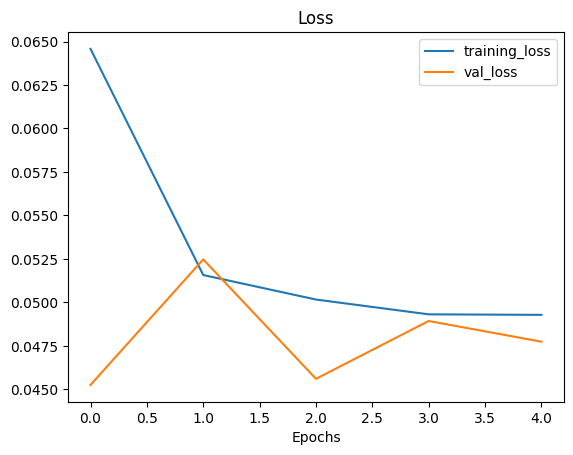

In [35]:
# Plot the Test and Validation Losses from our History 

import matplotlib.pyplot as plt

loss = TCC_history.history['loss']
val_loss = TCC_history.history['val_loss']

epochs = range(len(TCC_history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Make Predictions

In [36]:
# Make predictions using test data split

X_test, y_test = test.as_numpy_iterator().__next__() # Unpacking a batch
y_preds = model.predict(X_test)

y_preds = (y_preds>0.5).astype(int)

1/1 [==============================] - 1s 712ms/step


In [38]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [37]:
y_preds

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
# Comparing the 2 cells above, we can see the model seems to be doing pretty decent...

In [39]:
# Predicting using custom comments

test_text_1 = vectorizer("This was a great post!")
test_text_2 = vectorizer("You suck!")
test_text_3 = vectorizer("Terrible, I hate this!")
test_text_4 = vectorizer("I love you!")

In [40]:
result_1 = model.predict(np.expand_dims(test_text_1, axis=0))
result_2 = model.predict(np.expand_dims(test_text_2, axis=0))
result_3 = model.predict(np.expand_dims(test_text_3, axis=0))
result_4 = model.predict(np.expand_dims(test_text_4, axis=0))

1/1 [==============================] - 0s 46ms/step


In [41]:
# Look at how the results look
result_1
result_1[0]

array([8.9090951e-02, 4.2886706e-05, 1.1537462e-02, 3.3169219e-03,
       1.1504233e-02, 3.4649279e-03], dtype=float32)

In [43]:
# Display the results in the form of a DataFrame
results_df = pd.DataFrame([result_1[0], result_2[0], result_3[0], result_4[0]], columns=train_data.columns[2:])
results_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.089091,0.000043,0.011537,0.003317,0.011504,0.003465
1,0.998285,0.294600,0.969308,0.033797,0.847445,0.129587
2,0.516342,0.003303,0.126457,0.013381,0.140455,0.028853
3,0.075595,0.000031,0.009574,0.002987,0.009459,0.002952


# Evaluate the Model

In [45]:
# Import necessary metrics
from tensorflow.keras.metrics import Recall, CategoricalAccuracy

In [54]:
# Instantiate metrics
recall = Recall()
catAcc = CategoricalAccuracy()
Acc = Accuracy()

In [60]:
for batch in test.as_numpy_iterator():
    X_test, y_test = batch # Unpacking the Batch
    y_pred = model.predict(X_test, verbose=0)
    
    # Convert probabilities to class labels
    y_pred = (y_pred > 0.5).astype(int)
    
    # Flatten the Predictions
    y_pred = y_pred.flatten()
    y_test = y_test.flatten()

    recall.update_state(y_test,y_pred)
    Acc.update_state(y_test,y_pred)
    catAcc.update_state(y_test,y_pred)
    
print(f"""Recall: {recall.result().numpy()}
          Accuracy: {Acc.result().numpy()}
          Categorical Accuracy: {catAcc.result().numpy()}""")

Recall: 0.706926167011261
          Accuracy: 0.9825831651687622
          Categorical Accuracy: 0.7331995964050293


# Use Gradio to host the model temporarily and test predictions using that Interface

In [4]:
# Install gradio jinja
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 58.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5579 sha256=fc31af218d2f30625d744b33af4efb4a189a9c959c3facd99fd7d5c756744b18
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy


In [5]:
import gradio as gr

In [63]:
# Saving the Model
model.save("/kaggle/working/Toxic_Comment_Classifier.h5")

In [6]:
# Load the model
model = tf.keras.models.load_model("/kaggle/working/Toxic_Comment_Classifier.h5")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Predict on a text and Create a text formatting for displaying the output in a clear way
def check_comment(comment):
    vectorized_comment = vectorizer([comment])
    predictions = model.predict(np.expand_dims(vectorized_comment, axis=0))
    
    text = ""
    for index, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col, results[0][index]>0.5)
        
    return text

In [8]:
interface = gr.Interface(fn = check_comment,
                         inputs = gr.inputs.Textbox(lines=2, placeholder="Enter Comment to Check"),
                         outputs="text")

/tmp/ipykernel_28/4123014625.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.Textbox(lines=2, placeholder="Enter Comment to Check"),
/tmp/ipykernel_28/4123014625.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Textbox(lines=2, placeholder="Enter Comment to Check"),
/tmp/ipykernel_28/4123014625.py:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Textbox(lines=2, placeholder="Enter Comment to Check"),


In [9]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2f02db5dc8c6e79632.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
